## Seismic attributes that you can make

In [2]:
import numpy as np
import time
start = time.time()
 
data = np.loadtxt('../data/seismic_cube.txt')
 
end = time.time()
elapsed = end - start
print("Time taken to read volume: {:.2f} seconds.".format(elapsed))

Time taken to read volume: 33.58 seconds.


In [3]:
# Need to know:
nIL = 194  # number of inlines
nXL = 299  # number of crosslines
nt = 463   # number of samples per trace
dt = 0.004 # sample rate in seconds

volume = np.reshape(data, newshape = (nIL, nXL, nt))
print(volume.shape)

(194, 299, 463)


----
**Exercise**: Get rid of some bad data for the last few samples on each trace.

In [4]:
volume = volume[:,:,:450]
print(volume.shape)

(194, 299, 450)


### Temporal: operations on the whole trace

Complex trace attributes were introduced into geophysics by the paper

Taner, M. T., F. Koehler, and R. E. Sheriff, 1979, Complex seismic trace analysis: Geophysics, 44, 1041-1063. 

http://www.reproducibility.org/rsflog/index.php?/archives/274-Program-of-the-month-sfenvelope.html

If s(t) is the input seismic trace, then the analytical trace is defined as the complex valued signal

In [22]:
from IPython.display import Math

In [23]:
Math(r'a(t) = s(t)+ih(t)')

<IPython.core.display.Math object>

where h(t) is the Hilbert transform of s(t)

In [24]:
Math( r'h(t)= \frac{1}{\pi} \int \frac{ s \left( t \right)}{ t - \tau } d\tau' )

<IPython.core.display.Math object>

The signal envelop is the positive signal

In [25]:
Math(r'e\left ( t \right )=\sqrt{s^{2}\left ( t \right )+h^{2}\left ( t \right )}')

<IPython.core.display.Math object>

A phase rotated seismic signal is

In [26]:
Math(r'p\left ( t \right )=s\left ( t \right )cos\phi + h\left ( t \right )sin\phi')

<IPython.core.display.Math object>

In [27]:
from scipy.signal import hilbert

def envelope( s ):
    """
    Computes the envelope of a signal:
    :params s: The signal.
    :returns: envelope of signal
    """
    return abs(hilbert(s))

def rotate_phase( s, phi ):
    """
    Performs a phase rotation of wavelet using:
    A = w(t)Cos(phi) + h(t)Sin(phi)
    Where w(t) is the wavelet and h(t) is it's hilbert transform.
    
    :params s: The signal.
    :params phi: The phase rotation angle (in Radians) to apply.

    :returns: The phase rotated signal.
    """

    # Get the analytic signal for the wavelet
    a = hilbert( s )

    A = (np.real( a ) * np.cos( phi ) +
         np.imag( a  ) * np.sin( phi ) )

    return A

Consider a ricker wavelet

In [28]:
def ricker(f = 20, nsamps = 512, sr = 0.001):
    """
    f: frequency in Hz
    nsamps  :number of samples in the wavelet
    sr : sample rate in seconds
    """
    w = nsamps * sr # window length in seconds
    tw = np.linspace(-1*np.floor(nsamps/2)*sr, np.floor(nsamps/2)*sr, nsamps)
    term = np.pi*np.pi*f*f*tw*tw
    r = (1.0-2.0*term)*np.exp(-term)
    return r, tw

In [29]:
phi = -np.pi/3.0
sig, tw = ricker()
rot_sig = rotate_phase(sig, phi)
env_sig = envelope(sig)

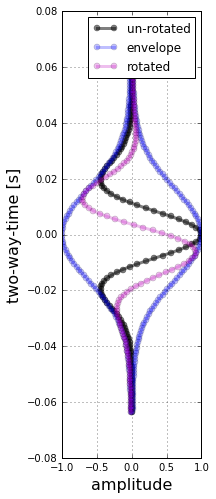

In [30]:
tcrop = 192
fig_env2 = plt.figure(figsize=[2.5,8])
ax3 = fig_env2.add_subplot(111)
ax3.plot( sig[tcrop:-tcrop],tw[tcrop:-tcrop],'ko-', lw=3, alpha=0.5, label = 'un-rotated')
ax3.plot( env_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'bo-', lw=3, alpha=0.25, label = 'envelope')
ax3.plot( -1.0*env_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'bo-', lw=3, alpha=0.25)
ax3.plot( rot_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'mo-', lw=3, alpha=0.25, label = 'rotated')

ax3.set_ylabel('two-way-time [s]', fontsize=16)
ax3.set_xlabel('amplitude', fontsize=16)
ax3.grid()
ax3.legend()

Make a plot of the real trace, the envelope, a +90 degree phase rotated trace.

In [31]:
phi = np.pi / 2.0 # 90 degrees in radians
e = envelope(s)
s90 = rotate_phase(s, phi)
i = 100
f = 250

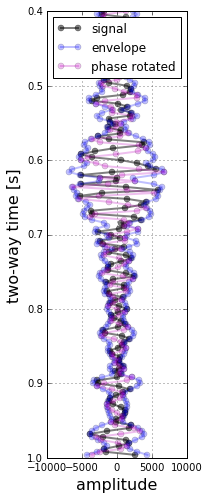

In [32]:
fig_env = plt.figure(figsize = (2.5,8), facecolor='w')
ax2 = fig_env.add_subplot(111)
ax2.plot( s[i:f], t[i:f],'ko-', lw=2, alpha = 0.5, label = 'signal')
ax2.plot( e[i:f], t[i:f],'bo-', lw = 2, alpha = 0.25,label = 'envelope')
ax2.plot( -1*e[i:f], t[i:f], 'bo-', lw = 2, alpha = 0.25)
ax2.plot( s90[i:f], t[i:f], 'mo-', lw = 2, alpha = 0.25, label = 'phase rotated')
ax2.legend()
ax2.set_xlabel('amplitude', fontsize = 16)
ax2.set_ylabel('two-way time [s]', fontsize = 16)
ax2.invert_yaxis()
ax2.grid()

Do envelope for entire line

In [33]:
env_line = np.empty_like(line)

for i,trace in enumerate(np.transpose(line)):
    env_line[:,i] = envelope(trace)

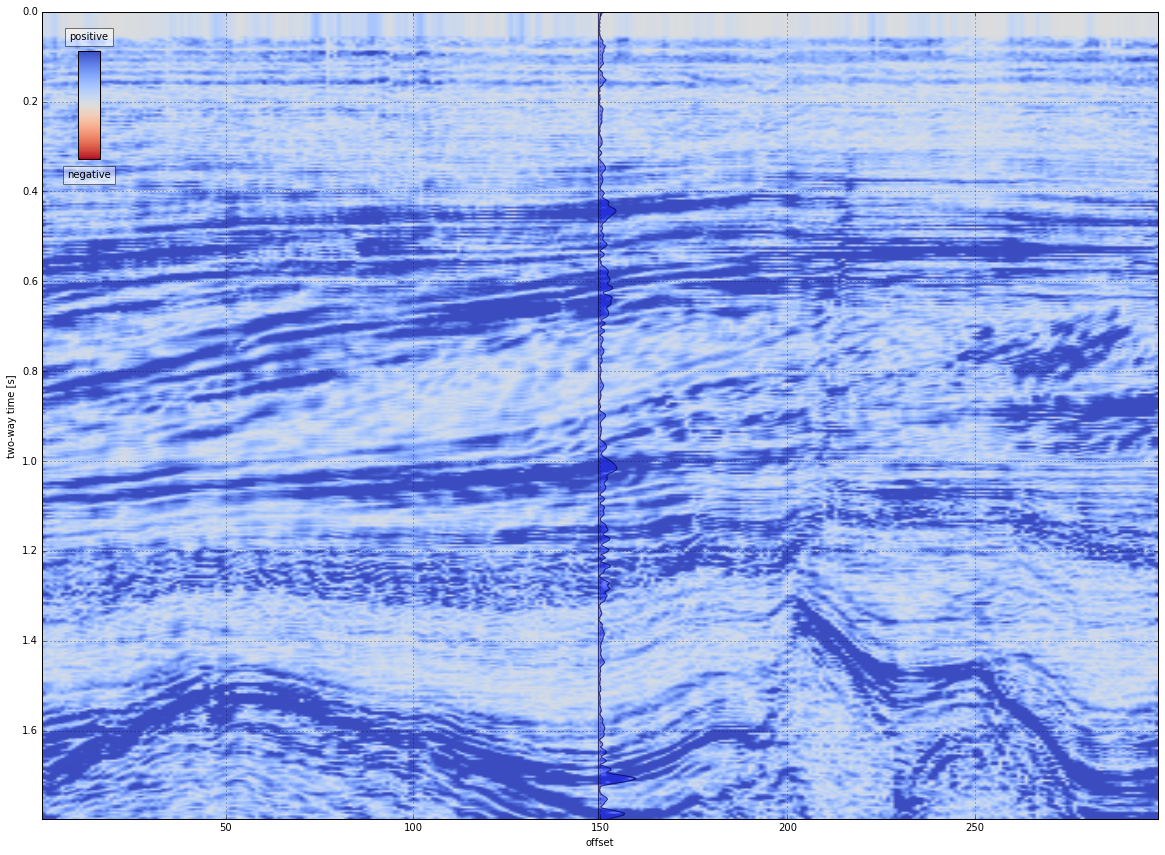

In [36]:
fig_envline = plt.figure(figsize = (20, 15), facecolor='white')
ax = fig_envline.add_subplot(111)
imenv = np.transpose(env_line)   # <--- must tranpose for image orientation
im = ax.imshow(imenv, cmap='coolwarm_r', vmin = vmin*0.5, vmax = vmax*0.5,
                extent =  (line_ext['first_trace'], 
                           line_ext['last_trace'], 
                           line_ext['end_time'], 
                           line_ext['start_time']), 
                aspect = 120 
                )
   
# plot the trace
#
# (Some cumbersome MPL plotting code)
#
ax.plot(x + 10*(e/np.amax(e)), t,'k', alpha = 0.5)
# plot positive values in wiggle trace blue
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(e/np.amax(e)), 
                  x2 = x,
                  where = e > 0,
                  alpha = 0.35,
                  color = 'b')
# plot negative values in wiggle trace red
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(e/np.amax(e)), 
                  x2 = x, 
                  where = e < 0,
                  alpha = 0.35,
                  color = 'r')
                      
# plot zero-crossing of the trace
ax.plot(x*np.ones_like(e), t, 'k', alpha = 0.5)

# create a colorbar axes
colorbar_ax = fig_envline.add_axes([0.15, 0.75, 0.015, 0.1])
# assign the im ScalarMappable to the colorbar
fig_envline.colorbar(im, cax=colorbar_ax)
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, -0.1, 'negative', bbox=dict(facecolor='white', alpha=0.5),
                      transform=colorbar_ax.transAxes,
                      horizontalalignment='center',
                      verticalalignment='top')
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, 1.1, 'positive',
                     transform=colorbar_ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                     horizontalalignment='center')
# turn off the colorbar ticks
colorbar_ax.set_axis_off()

# labels and grids
ax.set_xlim(left = line_ext['first_trace'], right = line_ext['last_trace'])
ax.set_xlabel('offset')
ax.set_ylim(bottom = line_ext['end_time'], top = line_ext['start_time'])
ax.set_ylabel('two-way time [s]')
ax.grid()

### Temporal: Statistical calculations within a moving window

Statistical calculations within a moving window. The simplest is energy within a moving window

In [38]:
# NOT NESSECARRILY FOR THE COURSE
from bruges.attribute import energy
window_length = 0.05 # in seconds
eRMS = energy(imline, duration = window_length, dt = 0.004)

x_nrg = eRMS[:,x]

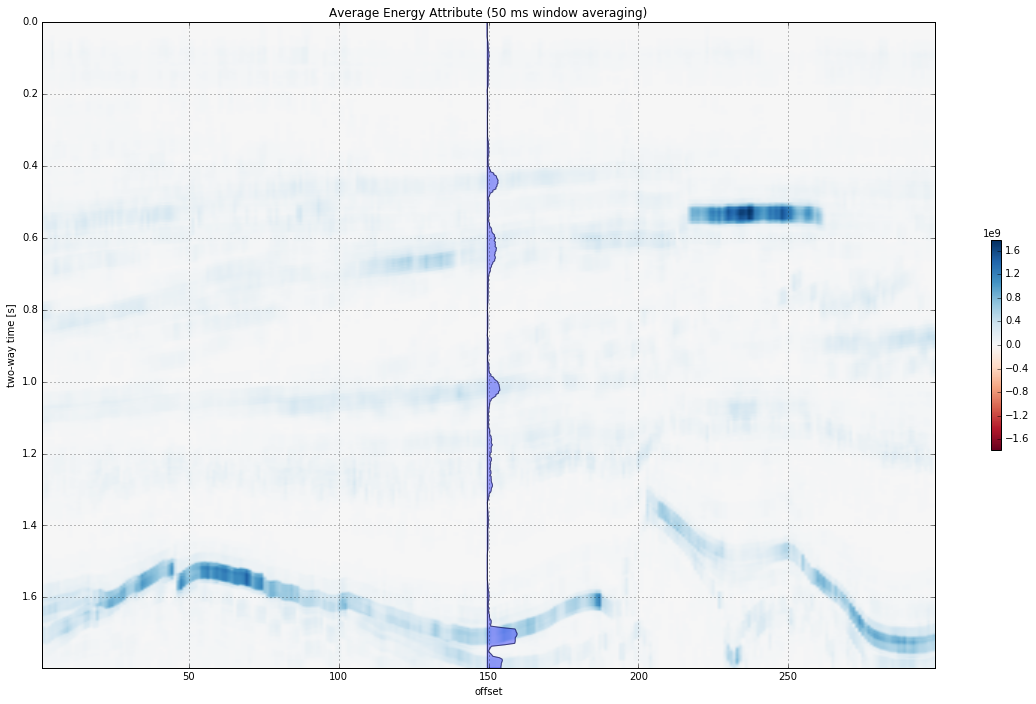

In [40]:
fig_energy = plt.figure(figsize = (20, 15), facecolor='white')
ax = fig_energy.add_subplot(111)

eRMS = energy(imline, duration = 0.05, dt = 0.004)   # <--- must tranpose for image orientation
im = plt.imshow(eRMS, cmap='RdBu', vmin = -1.0*np.amax(eRMS), vmax = np.amax(eRMS),
                extent =  (line_ext['first_trace'], 
                           line_ext['last_trace'], 
                           line_ext['end_time'], 
                           line_ext['start_time']), 
                aspect = 120 
                )

plt.colorbar(shrink=0.25)

# plot the trace
#
# (Some cumbersome MPL plotting code)
#
ax.plot(x + 10*(x_nrg/np.amax(x_nrg)), t,'k', alpha = 0.5)
# plot positive values in wiggle trace blue
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(x_nrg/np.amax(x_nrg)), 
                  x2 = x,
                  where = x_nrg > 0,
                  alpha = 0.35,
                  color = 'b')
# plot negative values in wiggle trace red
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(x_nrg/np.amax(x_nrg)), 
                  x2 = x, 
                  where = x_nrg < 0,
                  alpha = 0.35,
                  color = 'r')
                      
# plot zero-crossing of the trace
ax.plot(x*np.ones_like(x_nrg), t, 'k', alpha = 0.5)

# create a colorbar axes
colorbar_ax = fig_envline.add_axes([0.15, 0.75, 0.015, 0.1])
# assign the im ScalarMappable to the colorbar
fig_energy.colorbar(im, cax=colorbar_ax)
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, -0.1, 'negative', bbox=dict(facecolor='white', alpha=0.5),
                      transform=colorbar_ax.transAxes,
                      horizontalalignment='center',
                      verticalalignment='top')
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, 1.1, 'positive',
                     transform=colorbar_ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                     horizontalalignment='center')
# turn off the colorbar ticks
colorbar_ax.set_axis_off()

# labels and grids
ax.set_xlim(left = line_ext['first_trace'], right = line_ext['last_trace'])
ax.set_xlabel('offset')
ax.set_ylim(bottom = line_ext['end_time'], top = line_ext['start_time'])
ax.set_ylabel('two-way time [s]')
w_ms = 1000.0*window_length
ax.set_title('Average Energy Attribute (%d ms window averaging)' % w_ms)
ax.grid()

## Multi-trace attributes

Multi-trace attributes can be subdivided into calculations of discontinuity (or edge detection), and reflector dip estimation.

A few types of discontinutiy attributes are,

- Semblance (via autocorrelation), after Bahorich and Farmer

- Semblance within a window

- Eigenstructure coherence, after Marfurt et al.

A few types of reflector dip attributes are,

- Curvature (many kinds)
 
- Horizon interpolators

Curvature and horizon interpolation are algorithms that require a seismic volume of instantaneous reflector dip at each point. Also called dip estimation, or steering filters, these attributes are essentially vector fields describing the reflector morphology.




### The difference between one trace and another

From Barnes (2007): Redundant and useless seismic attributes:

Bahorich and Farmer 1995 introduced ameasure of seismic continuity
based on crosscorrelations between three traces in an L pattern.
Their measure is readily extended to compute continuity in an
analysis window encompassing an arbitrary number of traces. The
resulting correlation continuity attribute is similar in form to semblance
continuity and comparable to covariance continuity Marfurt
et al., 1998; Gersztenkorn and Marfurt, 1999. It is further generalized
by weighting the constituent correlations to produce a weighted
correlation continuity attribute. I provide the mathematics for these
two continuity measures without corrections for reflection dip. I implicitly
use a boxcar window operator, though windows could be tapered
to avoid Gibbs effects. For both measures, continuityC ranges
from 0 for perfectly discontinuous data to 1 for perfectly continuous
data. A corresponding measure of discontinuity D is formed as D
= 1 − C.
I simplify the mathematics by expressing seismic traces as vectors.
The zero-lag crosscorrelation of two traces xi and xj, each with
N samples, is given by

The zero lag cross-correlation between two traces xi and xj, each with N samples,

In [50]:
Math(r'x_{i}\cdot x_{j} = \sum_{k=1}^{N}x_{ik}x_{jk}')

<IPython.core.display.Math object>

where k is the sample index.

Energy Ei of a trace xi is the zero-lag autocorrelation of the trace,

In [51]:
Math(r'E_{i}=x_{i}\cdot x_{i} = \sum_{k=1}^{N}x_{i}^2')

<IPython.core.display.Math object>

The unit vector of the trace is the trace vector xi normalized by the square root of Energy,

In [52]:
Math(r'\hat{x_{i}}= \frac{x_{i}}{E_{i}}')

<IPython.core.display.Math object>

The average trace of a set of M traces is the vector average xa given by,

In [53]:
Math(r'x_{a}= \frac{1}{M} \sum_{i=1}^{M}x_{i}')

<IPython.core.display.Math object>

A correlation continuity measure C can be defined as the average of the squared cross-correlation between every trace and with the average trace

In [54]:
Math(r'C_{1} = \frac{1}{M} \sum_{i=1}^{M} ( \hat{x_{i}}\cdot \hat{x_{a}} )^{2}')

<IPython.core.display.Math object>

A weighted correlation continuity is the average of the squared cross-correlation between every trace with the average trace, with each cross-correlation weighted by the trace Energy, E,

In [55]:
Math(r'C_{2} = \frac{\sum_{i=1}^{M}\left (  x_{i}\cdot \hat{x_{a}}\right )^{2}}{\sum_{i=1}^{M}E_{i}}')

<IPython.core.display.Math object>

"This closely approximates covariance continuity but is computationally faster and does not assume zero-mean traces."

In [56]:
def C1(traces):
    
    x_ave = np.sum(traces, axis=1) / traces.shape[-1]
    
    x_ave_hat = x_ave / np.sqrt(np.dot(x_ave,x_ave))
    
    temp = []
    
    for xi in traces:
        xi_hat = xi / np.sqrt(np.correlate(xi,xi))
        
        temp += (np.dot(xi_hat, x_ave_hat))**2.0
        
    return temp / traces.shape[-1]

def C2(traces): 
    x_ave = np.sum(traces, axis=1) / traces.shape[-1]
    x_ave_hat = x_ave / np.sqrt(np.dot(x_ave,x_ave))
    numerator = 0
    denominator = 0 
    for i in range(traces.shape[-1]):
        xi = traces[...,i]
        numerator += (np.dot(xi, x_ave_hat))**2.0
        denominator += np.dot(xi,xi)
    return np.divide(numerator,denominator)

In [59]:
print (line.shape)
line_crop = np.transpose(line[50:100,370:430])
print (line_crop.shape)
print ('time_samples:' , line_crop.shape[0], 'traces:', line_crop.shape[1])

(299, 450)
(60, 50)
time_samples: 60 traces: 50


half window: 10
adjacent neighbours: 2


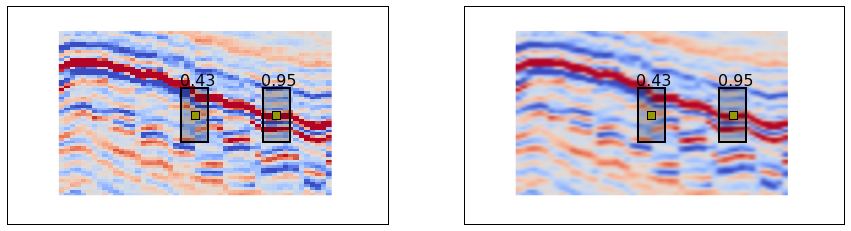

In [60]:
top = 20
bot = 40
ntr = 5
first_good = 37 
first_bad = 22  

C2_cont = (C2(line_crop[top:bot, first_good : first_good + ntr + 1  ]))
C2_discont = (C2(line_crop[top:bot , first_bad : first_bad + ntr + 1 ]))

# Let's add a rectangle to denote the area in each subsection
from matplotlib.transforms import Bbox
from matplotlib.path import Path

def example_plot(ax, img, i, gain=1.5):
    ax.imshow(img, 
              cmap = 'coolwarm_r', 
              interpolation = i, 
              vmin = vmin/gain,
              vmax = vmax/gain,
              aspect = 0.5)

    flipped = -1
    
    rect1 = plt.Rectangle(
                          (first_good, bot), 
                          ntr, 
                          flipped*(bot - top), 
                          facecolor=(0,0,0,0.2), ec='k', lw = 2)
    ax.add_patch(rect1)
    rect2 = plt.Rectangle(
                          (first_bad, bot), 
                          ntr,
                          flipped*(bot - top), 
                          facecolor=(0,0,0,0.2), ec='k', lw = 2)
    ax.add_patch(rect2)
    
    ax.scatter( x = [ first_good + ntr/2.0 , first_bad + ntr/2.0 ], 
                y = np.mean([top,bot])*np.ones(2), 
                s = 50, c = 'y',
                marker = 's',
                alpha = 1.0, 
                )
    
    # annotate continuous box
    ax.text(x = np.mean([first_good, first_good + ntr + 1]),
             y = top, 
             s = "{0:.2f}".format(C2_cont), 
             color = 'k',fontsize = 16,
             horizontalalignment='center',
             verticalalignment='bottom'
             )
    # annotate dicontinuous box
    ax.text(x = np.mean([first_bad,first_bad + ntr + 1]),
             y = top,
             s = "{0:.2f}".format(C2_discont),
             color = 'k',fontsize = 16,
             horizontalalignment='center',
             verticalalignment='bottom'
             ) 
    #ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])
interp = ['nearest', 'gaussian']
%matplotlib inline

fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=len(interp), figsize = (15,10), facecolor='w' )

axes = (ax1, ax2)
for ax, style in zip(axes,interp):
    example_plot(ax, line_crop ,style)

print ('half window:', int( (bot - top) / 2.0 ))
print ('adjacent neighbours:', int(np.floor(ntr/2.0)))

In [61]:
def continuity_attr(data, hw = 10 , ntr = 2):
    """ 
    :param data: amplitude data upon which to perform continuity calculation
    :param hw: number of samples in half-window (window size = 2*hw + 1)
    :param ntr: number of traces to use on either side of measurement point
    """
    # start the clock
    start = time.time()
    
    result = np.zeros_like(data)
    
    for i in range(hw , data.shape[0] - hw):
        for j in range(ntr , data.shape[1] - ntr):
            segment = data[i - hw : i + hw + 1 , j - ntr : j + ntr + 1]
            result[i,j] = C2(segment)
    
    end = time.time()
    #stop the clock
    
    elapsed = end - start
    
    print ("Time taken to compute continuity: ", int(elapsed), "seconds.")
    
    return result

In [62]:
imline = np.transpose(line)
print (imline.shape)

(450, 299)


In [63]:
continuity = continuity_attr(imline, hw = 10, ntr = 2)

Time taken to compute continuity:  4 seconds.


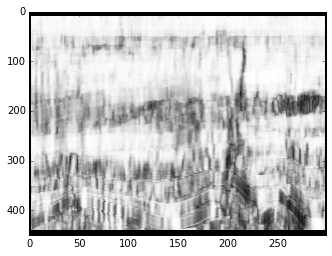

In [65]:
continuity.shape
plt.imshow(continuity, aspect=0.5, cmap='Greys_r')

In [66]:
def example_plot2(ax, img, cmap, vrange):
    ax.imshow(img, cmap = cmap, aspect = 0.5,
              vmin = vrange[0],
              vmax = vrange[-1]
              )
    rect1 = plt.Rectangle(
                          (50, 370), 
                          50,
                          60,
                          facecolor="y", ec='k', alpha = 0.25)
    ax.add_patch(rect1)
    ax.grid()

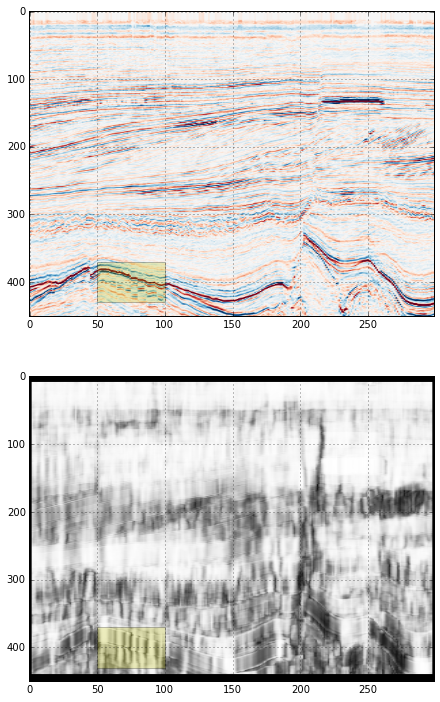

In [67]:
fig, (ax1, ax2) = plt.subplots( ncols = 1, nrows = len(interp) , figsize = (10, 12), facecolor='w' )
axes = (ax1, ax2)
data = [imline , continuity]
vrange = [ (vmin, vmax) , (np.amin(continuity), np.amax(continuity))  ]
cmaps = [ 'RdBu', 'Greys_r' ]

for ax, img, cmap, v in zip(axes, data, cmaps, vrange):
    example_plot2(ax, img, cmap, v)

NameError: name 'colorbar' is not defined

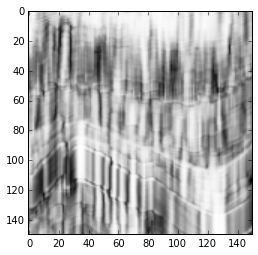

In [69]:
continuity.shape
plt.imshow(continuity[280:430, 20:170], cmap = 'Greys_r')
colorbar()

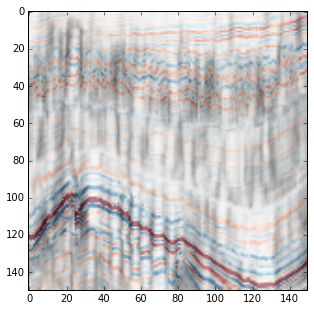

In [70]:
import numpy.ma as ma
c_subset = continuity[280:430, 20:170]
line_subset = np.transpose(line[20:170,280:430])
#c_mask = ma.masked_where(c_subset >= 0.9, c_subset)
fig_cont_mast, ax_cont = plt.subplots( nrows=1, ncols=1, figsize = (8,5), facecolor='w' )
ax_cont.imshow(line_subset, cmap = 'RdBu', vmin=vmin, vmax=vmax)
#ax_cont.imshow(c_mask, cmap = 'Greys_r', alpha =0.5)
ax_cont.imshow(c_subset, cmap = 'Greys_r', alpha =0.5)

ToDo: Calculate coherence on enveleop to avoid banding

In [71]:
continuity_env = continuity_attr(np.transpose(env_line)/np.amax(env_line))

Time taken to compute continuity:  4 seconds.


max, 0.997208303562
min, 0.997208303562


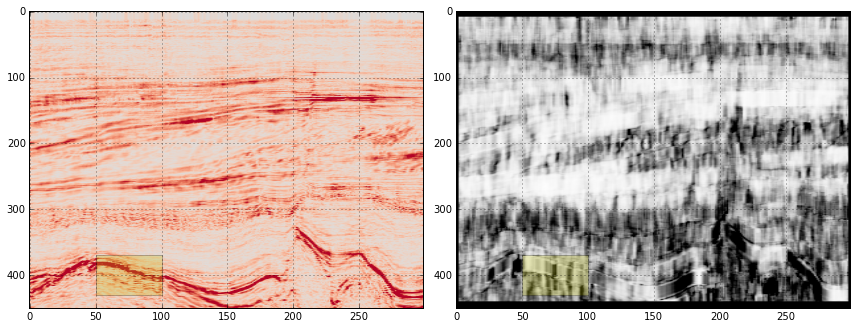

In [73]:
fig, (ax1, ax2) = plt.subplots( ncols = len(interp), nrows = 1 , figsize = (12, 6), facecolor='w' )
axes = (ax1, ax2)
data = [np.transpose(env_line) , continuity_env]
cmaps = [ 'coolwarm', 'Greys_r' ]
print ("max,", np.amax(continuity_env))
print ("min,", np.amax(continuity_env))
vrange = [ (vmin, vmax) , (0.85, 1.0)  ]
for ax, img, cmap, v in zip(axes, data, cmaps, vrange ):
    example_plot2(ax, img, cmap, v)
fig.tight_layout()

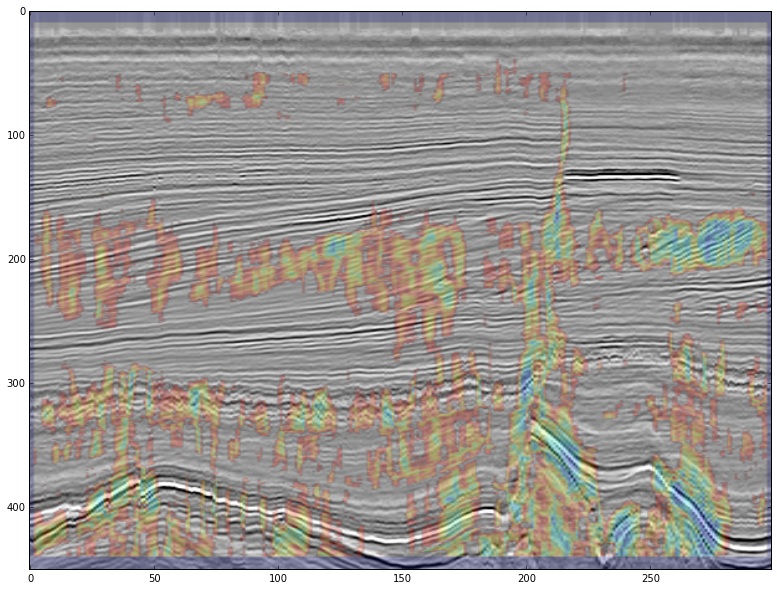

In [74]:
def get_extents(data, x1 = 100, x2 = 350, y1 = 0, y2 = 400):
    return data[x1:x2, y1:y2]

#line_crop = get_extents(line)
c_subset = get_extents(continuity_env)
c_mask = ma.masked_where(continuity >= 0.6, continuity)

aspect = 0.5

fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (16,10), facecolor='w' )
ax.imshow(imline, cmap = 'Greys', vmin = -10000, vmax = 10000, aspect = aspect)
ax.imshow(c_mask, cmap = 'jet', alpha = 0.25, aspect = aspect)

Do it for all lines in a volume

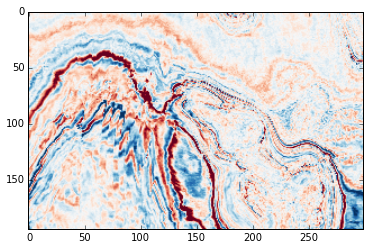

In [76]:
plt.imshow(np.flipud(volume[:,:,420]), cmap = 'RdBu', vmin=vmin, vmax=vmax)

In [77]:
def C2vol(traces): 
    x_ave = np.sum(traces, axis=1) / traces.shape[-1]
    x_ave_hat = x_ave / np.sqrt(np.dot(x_ave,x_ave))
    numerator = 0
    denominator = 0 
    for i in range(traces.shape[-1]):
        xi = traces[...,i]
        numerator += (np.dot(xi, x_ave_hat))**2.0
        denominator += np.dot(xi,xi)
    return np.divide(numerator,denominator)

def get_traces(data, x, dx, y, dy, z, dz):
    kernel = data[z:z+dz+1 , y:y+dy+1 , x:x+dx+1]
    return kernel

In [79]:
def continuity_attr(data, hw = 10 , ix = 2, iy = 2):
    """ 
    :param data: amplitude data upon which to perform continuity calculation
    :param hw: number of samples in half-window (window size = 2*hw + 1)
    :param ntr: number of traces to use on either side of measurement point
    """
    #print data.shape
    start = time.time()
    
    result =  np.zeros_like(data)
    segment = np.zeros( (ix * iy , 2*hw + 1))
    
    for i in range(hw , data.shape[2] - hw):
        for j in range (ix , data.shape[1] - ix):
            for k in range (iy , data.shape[0] -iy):
                
                segment = data[ k-iy: k+iy ,
                                j-ix: j+ix ,
                                i-hw: i+hw +1
                               ]
                #print segment.shape
                new_shape = segment.reshape(2*ix*2*iy , 2*hw+1)
                #print  new_shape.shape
                result[k,j,i] = C2(np.transpose(new_shape))
                
    end = time.time()
    #stop the clock
    
    elapsed = end - start
    
    print ("Time taken to compute continuity: ", int(elapsed), "seconds.")
    
    return result

In [80]:
volume.shape

(194, 299, 450)

### The next block of code could take a minute or two.

In [ ]:
cont_sub_vol = continuity_attr(volume, ix=1, iy=1)

In [334]:
cvol_mask = np.masked_where(cont_sub_vol >= 0.8, cont_sub_vol)

AttributeError: 'module' object has no attribute 'masked_where'

In [ ]:
fig=plt.figure(figsize=(15,15), facecolor='w')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('amplitude')
ax1.imshow(np.flipud(volume[:,:200,-20]), cmap='coolwarm_r', vmin=0.5*vmin, vmax=0.5*vmax)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
# Try
#ax2.imshow(np.flipud(cvol_mask[:,:,20]), cmap='Greys_r',alpha=0.5)
#ax2.imshow(np.flipud(sub_vol[:,:200,20]), cmap='RdBu', vmin=0.5*vmin, vmax=0.5*vmax)
ax2.set_title('continuity')
ax2.imshow(np.flipud(cont_sub_vol[:,:200,-20]), cmap='Greys_r',alpha=1.0, vmax =1.0, vmin = 0.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3.set_title('amplitude and continuity')
ax3.imshow(np.flipud(volume[:,:200,-20]), cmap='RdBu', vmin=0.5*vmin, vmax=0.5*vmax)
ax3.imshow(np.flipud(cont_sub_vol[:,:200,-20]), cmap='Greys_r',alpha=0.75, vmax =1.0, vmin = 0.3)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

In [ ]:
# Export amplitude slice
amp_slice = volume[:,:200,-20]
# Export continuity slice
cont_slice = cont_sub_vol[:,:200,-20]

np.save('amp_slice',amp_slice)
np.save('cont',cont_slice)

In [335]:
data_n=(amp_slice+ (amp_slice.min())/1.65)/(1.15*amp_slice.min())
img_array = plt.get_cmap('coolwarm_r')(data_n)

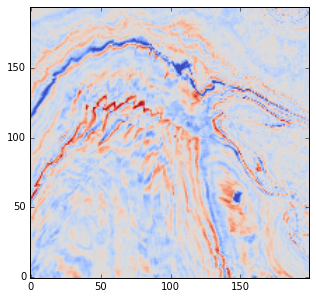

In [337]:
# Modulate lightness with Continuity
hsv = rgb_to_hsv(img_array[:,:,:3])
#hsv[:, :, 2] *= cont_slice
new = hsv_to_rgb(hsv)

# Display blend
fig = plt.figure(figsize=(5,5))
plt.imshow(new, origin='bottom')
plt.show()

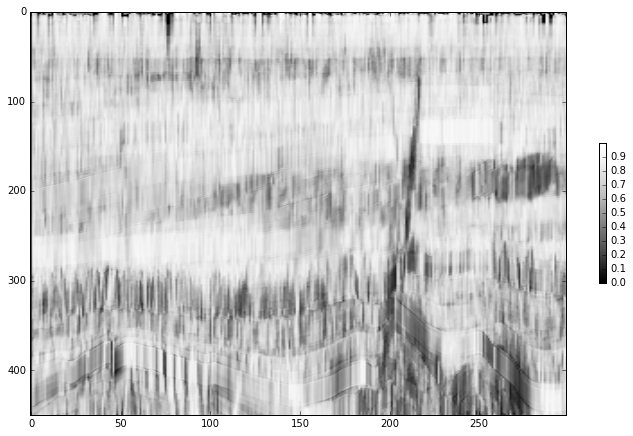

In [260]:
# NOT FOR THIS COURSE
from agilegeo.attribute import similarity
sim = similarity(imline, 0.1, dt = 0.004, step_out=1)
plt.figure(figsize = (12, 10), facecolor='white')
plt.imshow(sim, cmap='Greys_r', aspect = 0.5)
plt.colorbar(shrink=0.25)